# compute spatiotemporal autocovariances

Strategy:

- bin spatially with a combination of geohash indexing and geopandas
- figure out size


other links:

https://www.reddit.com/r/learnpython/comments/4rj7ie/how_to_find_the_difference_between_all_pairs_of/

https://towardsdatascience.com/finding-distant-pairs-in-python-with-pandas-fa02df50d14b



http://kuanbutts.com/2017/06/18/dask-geoprocessing/

https://towardsdatascience.com/geospatial-operations-at-scale-with-dask-and-geopandas-4d92d00eb7e8

https://geoffboeing.com/2016/10/r-tree-spatial-index-python/

https://blog.mapbox.com/a-dive-into-spatial-search-algorithms-ebd0c5e39d2a

https://automating-gis-processes.github.io/site/notebooks/L3/spatial_index.html

https://github.com/uber/h3-py-notebooks/blob/master/notebooks/urban_analytics.ipynb


In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import geopandas as gpd
#world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
from shapely.geometry import Polygon, Point
from shapely import wkt
import pyproj
crs_wgs84 = pyproj.CRS("EPSG:4326")

%matplotlib inline
from matplotlib import pyplot as plt

import pyinterp.geohash as geohash
#import pyinterp.geodetic as geodetic

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.dr as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4452041.datarmor0/parcels-55081/libparcels_random_f4e32d7e-3618-40fd-bcbe-7403c854da22.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=10)
    #
    client = Client(cluster)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.147:49628 Dashboard: http://10.148.0.147:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


10 jobs = 70 workers = 1.1TB (15GB/worker)

--- 

# parameters

In [3]:
dl = 5 # target tile size
geohash_resolution = 2 # for geohash indexing

d2h=24

---
# load parcels simulation

In [5]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['geohash_p{}'.format(geohash_resolution)])
df = p['geohash_p{}'.format(geohash_resolution)]
df.head()

,trajectory,time,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
geohash,,,,,,,,,,
04,31000046,2011-11-15,-78.004211,-173.134735,0.0,0.0,0.0,0.0,0.0,0.0
04,31000047,2011-11-15,-77.646156,-173.440277,0.0,0.0,0.0,0.0,0.0,0.0
04,31000048,2011-11-15,-77.283386,-173.719879,0.0,0.0,0.0,0.0,0.0,0.0
04,31000062,2011-11-15,-78.312302,-171.702026,0.0,0.0,0.0,0.0,0.0,0.0
04,31000063,2011-11-15,-77.961166,-172.041321,0.0,0.0,0.0,0.0,0.0,0.0


---

# generate spatial tiles

<ipython-input-6-fb412cb4b009>:30: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buff['geometry'] = gdf.buffer(dl)


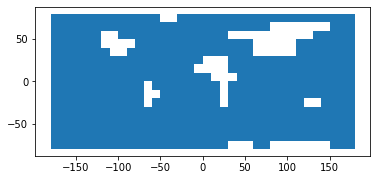

In [7]:
df_boxes, df_buff_boxes = dr.generate_grid_and_geohashes(dl, 
                                                         geohash=geohash_resolution,
                                                         plot=True,
                                                         buffered=True,
                                                        )
hash_boxes = dr.get_geohashes(geohash_resolution)

In [7]:
# load geohash that are effectively used
index_unique = df.index.unique().compute()

In [8]:
# test with one box

idx = 398 # North of Hawaii
box = df_boxes.loc[df_boxes.index==idx]
box_buff = df_buff_boxes.loc[df_buff_boxes.index==idx]

# keep only valid geohashes where points are found
valid_geohash = list(set(index_unique) 
                     & set(box_buff.loc[:,"geohash"].values.astype(str))
                    )

# first guess based on geohashes
df_fguess = df.loc[valid_geohash,:]

# repartition
#df_fguess = df_fguess.repartition(partition_size="100MB")

print("First guess number of partitions = {}".format(df_fguess.npartitions))

df_fguess.head()

First guess number of partitions = 16


,trajectory,time,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
geohash,,,,,,,,,,
j5,12000847,2012-11-07 09:00:00,-67.632821,45.302380,0.0,6.827644e-07,1.478475e-07,-2.312811,-1.864458,33.993401
j5,12000861,2012-10-02 19:00:00,-67.675932,45.450033,0.0,-6.942295e-07,7.510351e-08,-1.778488,-1.864971,34.001225
j5,12001138,2012-08-15 18:00:00,-67.696750,45.488526,0.0,9.318196e-07,-9.421901e-08,-2.495726,-1.870825,34.104137
j5,12000861,2012-10-01 01:00:00,-67.709223,45.519700,0.0,-3.253638e-08,7.832219e-08,-1.789120,-1.863419,33.974247
j5,12001011,2012-10-01 04:00:00,-67.526936,45.694026,0.0,-1.648694e-06,-3.785519e-07,-2.482025,-1.873334,34.155121


Should illustrate visually the spatial selection process below

In [28]:
def refine_spatial_selection(df, boxes):
    
    box=boxes[0]
    box_buff=boxes[1]
        
    # transform into geopandas dataframe
    gdf = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df.lon, df.lat),
        crs=crs_wgs84,
    )
    # narrow selection
    _box_buff = box_buff.iloc[[0],:].drop(columns="geohash")
    gdf_refined = gpd.sjoin(gdf, 
                            _box_buff,
                            how='inner',
                            op='intersects',
                           )
    
    # keep geodataframe does not work later on when storing
    #return gdf_refined
    
    # flag points within inner domain
    gdf_refined["within_box"] = gdf_refined["geometry"].apply(lambda row: box.contains(row))
    
    # convert back to regular dataframe
    df_refined = pd.DataFrame(gdf_refined.drop(columns='geometry'))
    
    return df_refined

In [11]:
# test on one partition
#out = refine_spatial_selection(df_fguess.get_partition(0).compute(), box=box, box_buff=box_buff)
#out

,trajectory,time,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,index_right,within_box
geohash,,,,,,,,,,,,
j7,12001481,2012-10-04 21:00:00,-67.500953,66.909819,0.0,2.061029e-08,2.673069e-07,0.095451,-1.888398,34.409042,60,True
j7,12001771,2012-10-30 02:00:00,-67.620662,62.510419,0.0,4.040395e-12,5.678511e-10,-3.493800,-1.895815,34.537655,60,True
j7,12001771,2012-09-16 01:00:00,-67.620822,62.510770,0.0,-1.474237e-09,-9.720222e-11,-3.458212,-1.899933,34.609261,60,True
j7,12001771,2012-11-08 21:00:00,-67.620247,62.510418,0.0,-1.527635e-12,-2.248119e-10,-3.231414,-1.893601,34.499149,60,True
j7,12001652,2012-09-06 00:00:00,-67.579142,66.406580,0.0,-1.520236e-06,2.718240e-07,-0.504639,-1.888597,34.412102,60,True
...,...,...,...,...,...,...,...,...,...,...,...,...
j7,12001024,2012-06-18 06:00:00,-67.532939,61.555880,0.0,-1.306527e-06,-1.589941e-08,-0.629211,-1.893061,34.489750,60,True
j7,12000518,2012-01-19 16:00:00,-67.532249,61.635208,0.0,-1.049102e-06,-3.144959e-09,0.235704,-1.831282,33.793995,60,True
j7,12000518,2012-01-22 00:00:00,-67.532316,61.552143,0.0,5.524095e-08,1.177341e-07,-0.782266,-1.844740,33.839230,60,True


In [41]:
meta = dict(**df_fguess.dtypes, index_right=np.int64, within_box=bool)
df_refined = df_fguess.map_partitions(refine_spatial_selection, [box, box_buff], meta=meta)
#df_refined = df_fguess.map_partitions(refine_spatial_selection, box=box, box_buff=box_buff)
df_refined.head()

,trajectory,time,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,index_right,within_box
geohash,,,,,,,,,,,,
j7,12001481,2012-10-04 21:00:00,-67.500953,66.909819,0.0,2.061029e-08,2.673069e-07,0.095451,-1.888398,34.409042,60,True
j7,12001771,2012-10-30 02:00:00,-67.620662,62.510419,0.0,4.040395e-12,5.678511e-10,-3.493800,-1.895815,34.537655,60,True
j7,12001771,2012-09-16 01:00:00,-67.620822,62.510770,0.0,-1.474237e-09,-9.720222e-11,-3.458212,-1.899933,34.609261,60,True
j7,12001771,2012-11-08 21:00:00,-67.620247,62.510418,0.0,-1.527635e-12,-2.248119e-10,-3.231414,-1.893601,34.499149,60,True
j7,12001652,2012-09-06 00:00:00,-67.579142,66.406580,0.0,-1.520236e-06,2.718240e-07,-0.504639,-1.888597,34.412102,60,True


In [44]:
# reindex by time ... kind of heavy computationally
# probably need a real cluster and data storage
df_refined = df_refined.set_index("time")

# should may be repartition into small partitions here?

parquet_path = os.path.join(ut.scratch, "tmp.parquet")
df_refined.to_parquet(parquet_path, overwrite=True)

---
### start pair selection

In [4]:
# build lag grid
ll_scale = 111
dx, x_max = 2, dl*111 # km
dy, y_max = 2, dl*111 # km
#dtau, tau_max = pd.Timedelta("1H"), pd.Timedelta("30D")
#dtau, tau_max = 1/24, 30 # days
tau_max = 30*d2h # hours

x_bins = np.arange(-x_max, x_max, dx) # km
y_bins = x_bins # km
#tau_bins = [n*dtau for n in range(int(tau_max/dtau))]
#tau_bins = np.arange(0, tau_max, dtau) # days

In [22]:
parquet_path = os.path.join(ut.scratch, "tmp.parquet")
df = dd.read_parquet(parquet_path, engine="fastparquet")[["lat", "lon", "zonal_velocity", "within_box"]]
print(df.npartitions, df.size.compute())
df.head()

16 22550324


,lat,lon,zonal_velocity,within_box
time,,,,
2011-11-15,-61.478786,68.385414,0.0,True
2011-11-15,-67.230316,70.468750,0.0,False
2011-11-15,-66.826096,70.468750,0.0,False
2011-11-15,-66.416069,70.468750,0.0,False
2011-11-15,-66.000099,70.468750,0.0,False


In [23]:
worker_RAM = 10 # GB
n_col = len(df.columns)
rows = int(np.sqrt(worker_RAM*1e9/(2*n_col*4)))
p_size_even = rows*n_col*4 /1e6

print("even distribution: {} rows, {:.2f} MB".format(rows, p_size_even))

even distribution: 17677 rows, 0.28 MB


In [24]:
# roll over time
t_min = df.index.min().compute()
t_max = df.index.max().compute()
delta_t = pd.Timedelta(tau_max, unit='h')

In [37]:
t=t_min
# while t < t_max:
#     ...
#     t=t+delta_t

df_right = df.loc[str(t):str(t+delta_t), :] # will end up being df_small
df_left = df.loc[str(t):str(t+2*delta_t), :]

In [38]:
# repartition
p_size = p_size_even/2 # goes through with division by 2 may not go through with 1
df_left = df_left.repartition(partition_size="{}MB".format(p_size))
df_right = df_right.repartition(partition_size="{}MB".format(p_size))

# add temp_key
df_left = df_left.assign(temp_key=1)
df_right = df_right.assign(temp_key=1)

df_left = df_left.reset_index().persist() #test
df_right = df_right.reset_index().persist() #test

print("Left: number of partitions = {}, number of rows = {}"
      .format(df_left.npartitions, df_left.index.size.compute())
     )
print("Right: number of partitions = {}, number of rows = {}"
      .format(df_right.npartitions, df_right.index.size.compute())
     )

Left: number of partitions = 105, number of rows = 504371
Right: number of partitions = 54, number of rows = 258465


In [44]:
# compute deltas and bin

def haversine(lon1, lat1, lon2, lat2):
    """Computes the Haversine distance in kilometres between two points
    :param x: first point or points as array, each as array of latitude, longitude in degrees
    :param y: second point or points as array, each as array of latitude, longitude in degrees
    :return: distance between the two points in kilometres
    """
    earth_radius = 6378.0
    deg2rad = np.pi / 180.0
    llat1 = lat1 * deg2rad
    llat2 = lat2 * deg2rad
    llon1 = lon1 * deg2rad
    llon2 = lon2 * deg2rad
    arclen = 2 * np.arcsin(
        np.sqrt(
            (np.sin((llat2 - llat1) / 2)) ** 2
            + np.cos(llat1) * np.cos(llat2) * (np.sin((llon2 - llon1) / 2)) ** 2
        )
    )
    return arclen * earth_radius


def compute_deltas(df, bins):
    """ compute deltas and round
    """
    x_bins = bins[0]
    y_bins = bins[1]
    tau_max = bins[2]
    
    df = df.copy()
    # get rid of duplicates: necessary?
    df = df.loc[ ( (df["zonal_velocity_left"]!=df["zonal_velocity_right"]) 
                  |(df["lon_left"]!=df["lon_right"]) 
                  |(df["lat_left"]!=df["lat_right"])
                 )
                & (df["within_box_left"] | df["within_box_right"])
               ]
    #
    # should use cartopy or other?
    dx = haversine(df["lon_right"], df["lat_right"], df["lon_left"], df["lat_right"])
    dx = np.sign(df["lon_right"]-df["lon_left"]) * dx
    df["dx"] = pd.cut(dx, bins=x_bins, labels=False)
    #
    dy = haversine(df["lon_right"], df["lat_right"], df["lon_right"], df["lat_left"])
    dy = np.sign(df["lat_right"]-df["lat_left"]) * dy    
    df["dy"] = pd.cut(dy, bins=y_bins, labels=False)
    #
    df["dt"] = (df["time_left"]-df["time_right"])/pd.Timedelta("1H")
    #
    df = df.loc[df["dt"]<tau_max]
    df = df.dropna(subset=["dx", "dy", "dt"])
    #
    df["uu"] = df["zonal_velocity_left"] * df["zonal_velocity_right"]
    return df[["dx", "dy", "dt", "uu"]]

In [45]:
client

Client Scheduler: tcp://10.148.0.147:49628 Dashboard: http://10.148.0.147:8787/status,Cluster Workers: 69 Cores: 69 Memory: 1.08 TiB


In [52]:
def process_partition(partition, df_left, df_right, bins, verbose=True):

    df_small = df_right.get_partition(partition).compute()

    merged_ddf = dd.merge(df_left, df_small, on="temp_key", suffixes=("_left", "_right"))
    merged_ddf = merged_ddf[merged_ddf.time_left >= merged_ddf.time_right]
    merged_ddf

    deltas = merged_ddf.map_partitions(compute_deltas, bins)
    #deltas = deltas.set_index("dt") # will be done later on at read time

    parquet_path = os.path.join(ut.scratch, "tmp_delta_{:04d}.parquet".format(partition))
    deltas.to_parquet(parquet_path, overwrite=True)
    
    if verbose:
        print(" partition {} done".format(partition))

In [54]:
# manually loop over partitions and load one:
print("Number of partitions: {}".format(df_right.npartitions))

bins = [x_bins, y_bins, tau_max]

#partition = 20
for partition in range(df_right.npartitions):
    process_partition(partition, df_left, df_right, bins)

Number of partitions: 54
 partition 0 done
 partition 1 done
 partition 2 done
 partition 3 done
 partition 4 done
 partition 5 done
 partition 6 done
 partition 7 done
 partition 8 done
 partition 9 done
 partition 10 done
 partition 11 done
 partition 12 done
 partition 13 done
 partition 14 done
 partition 15 done
 partition 16 done
 partition 17 done
 partition 18 done
 partition 19 done
 partition 20 done
 partition 21 done
 partition 22 done
 partition 23 done
 partition 24 done
 partition 25 done
 partition 26 done
 partition 27 done
 partition 28 done
 partition 29 done
 partition 30 done
 partition 31 done
 partition 32 done
 partition 33 done
 partition 34 done
 partition 35 done
 partition 36 done
 partition 37 done
 partition 38 done
 partition 39 done
 partition 40 done
 partition 41 done
 partition 42 done
 partition 43 done
 partition 44 done
 partition 45 done
 partition 46 done
 partition 47 done
 partition 48 done
 partition 49 done
 partition 50 done
 partition 51 do

In [55]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [20]:
client.restart()

distributed.scheduler - ERROR - Not all workers responded positively: ['timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out']
NoneType: None


Client Scheduler: tcp://10.148.0.147:49628 Dashboard: http://10.148.0.147:8787/status,Cluster Workers: 53 Cores: 53 Memory: 846.41 GiB


In [129]:
worker_RAM = 10 # GB
p_size = 10 # MB
n_col = len(df.columns)
small_rows = int(worker_RAM*1e3/p_size/2)
small_p_size = small_rows*n_col*4 /1e6
print("Small vector size should be: {} rows / {} MB".format(small_rows, small_p_size))

Small vector size should be: 500 rows / 0.01 MB


```
# for info
tmp = df.loc["2012-01-01":"2012-03-01", :]
tmp = tmp.compute()
print("Number of rows={}".format(tmp.index.size))
tmp.memory_usage()/1e6 # MB


Number of rows=648767

Index             5.190136
lat               5.190136
lon               5.190136
zonal_velocity    2.595068
within_box        0.648767
dtype: float64
```

In [73]:
# memory footprint square partition

if False:

    p_size = np.arange(0, 2, .2) # MB
    rows = (p_size *1e6/(n_col*4)).astype(int)
    footprint = rows*rows*n_col*4/1e9 # GB

    footprint

array([  0.        ,   1.66653334,   6.66613334,  15.        ,
        26.66613334,  41.66533334,  60.        ,  81.66573334,
       106.66453334, 135.        ])

In [7]:
# roll over time
t = df.index.min().compute()
delta_t = pd.Timedelta(tau_max, unit='h')

df = df.loc[str(t):str(t+2*delta_t), :]

In [8]:
# repartition

p_size = p_size_even/10
df = df.repartition(partition_size="{}MB".format(p_size))

# add temp_key
df = df.assign(temp_key=1).reset_index()
df = df.persist() #test

#1MB too small probably
print(df.npartitions, df.size.compute())

518 3026226


In [9]:
# manually loop over partitions and load one:
print("Number of partitions: {}".format(df.npartitions))

# for partition in range(df.npartitions):
partition = 20

df_small = df.get_partition(partition).compute()

merged_ddf = dd.merge(df, df_small, on="temp_key", suffixes=("_left", "_right"))
#merged_ddf = dd.merge(_df, df_small, on="temp_key", suffixes=("_left", "_right"))
merged_ddf = merged_ddf[merged_ddf.time_right >= merged_ddf.time_left]
merged_ddf

Number of partitions: 518


,time_left,lat_left,lon_left,zonal_velocity_left,within_box_left,temp_key,time_right,lat_right,lon_right,zonal_velocity_right,within_box_right
npartitions=518,,,,,,,,,,,
,datetime64[ns],float64,float64,float32,bool,int64,datetime64[ns],float64,float64,float32,bool
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [133]:
# test
#df = df.set_index("temp_key")

#merged_ddf = dd.merge(df, df, suffixes=("_left", "_right"), left_index=True, right_index=True)
merged_ddf = dd.merge(df, df, on="temp_key", suffixes=("_left", "_right"))
merged_ddf = merged_ddf[merged_ddf.time_right >= merged_ddf.time_left]

merged_ddf

,time_left,lat_left,lon_left,zonal_velocity_left,within_box_left,temp_key,time_right,lat_right,lon_right,zonal_velocity_right,within_box_right
npartitions=518,,,,,,,,,,,
,datetime64[ns],float64,float64,float32,bool,int64,datetime64[ns],float64,float64,float32,bool
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
merged_ddf.mean().compute()

In [ ]:
merged_ddf.index.size.compute()

In [114]:
575245*2*n_col*4/1e9

0.01840784

In [115]:
tmp = merged_ddf.persist()


In [116]:
tmp

,time,lat,lon,zonal_velocity,within_box
npartitions=518,,,,,
,datetime64[ns],float64,float64,float32,bool
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [80]:
# load repartitionned data (smaller partitions)
#psize = "0.1MB"
psize = "{:.2f}MB".format(small_p_size)
print("repartition in "+psize+" large partitions")
df_smallp = df.repartition(partition_size=psize)

# distribute
df_small = df_smallp.get_partition(0).compute()
df_small.size

repartition in 0.01MB large partitions


1578

In [81]:
merged_ddf = dd.merge(df, df_small, on="temp_key", suffixes=("_left", "_right"))
#merged_ddf = dd.merge(_df, df_small, on="temp_key", suffixes=("_left", "_right"))
merged_ddf = merged_ddf[merged_ddf.time_right >= merged_ddf.time_left]
merged_ddf

,time_left,lat_left,lon_left,zonal_velocity_left,within_box_left,temp_key,time_right,lat_right,lon_right,zonal_velocity_right,within_box_right
npartitions=53,,,,,,,,,,,
,datetime64[ns],float64,float64,float32,bool,int64,datetime64[ns],float64,float64,float32,bool
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [10]:
# compute deltas and bin

def compute_deltas(df):
    """ compute deltas and round
    """
    df = df.copy()
    #print(df.index.size)
    # get rid of duplicates: necessary?
    df = df.loc[ ( (df["zonal_velocity_left"]!=df["zonal_velocity_right"]) 
                  |(df["lon_left"]!=df["lon_right"]) 
                  |(df["lat_left"]!=df["lat_right"])
                 )
                & (df["within_box_left"] | df["within_box_right"])
               ]
    #print(df.index.size)
    #
    # should use cartopy?
    dx = pa.haversine(df["lon_right"], df["lat_right"], df["lon_left"], df["lat_right"])
    dx = np.sign(df["lon_right"]-df["lon_left"]) * dx
    df["dx"] = pd.cut(dx, bins=x_bins).rename("dx")
    #
    dy = pa.haversine(df["lon_right"], df["lat_right"], df["lon_right"], df["lat_left"])
    dy = np.sign(df["lat_right"]-df["lat_left"]) * dy    
    df["dy"] = pd.cut(dy, bins=y_bins).rename("dy")
    #
    df["dt"] = (df["time_right"]-df["time_left"])/pd.Timedelta("1H")
    #df["dt"] = pd.cut(dt, bins=tau_bins, include_lowest=True).rename("dt")
    # drop lags that are too large
    df = df.dropna(subset=["dx", "dy", "dt"])
    #print(df.index.size)
    #
    df["uu"] = df["zonal_velocity_left"] * df["zonal_velocity_right"]
    #out = df.groupby(["dt", "dx", "dy"])["uu"].mean()
    #return out
    return df[["dx", "dy", "dt", "uu"]]

#out = merged_ddf.map_partitions(bin_deltas).get_partition(0)
#out

In [11]:
out = merged_ddf.map_partitions(compute_deltas).persist()

In [14]:
out.index.size.compute()

3432049

In [15]:
out = out.compute()

In [16]:
out.memory_usage()/1e6

Index    27.456392
dx        6.889514
dy        6.889514
dt       27.456392
uu       13.728196
dtype: float64

In [151]:
del out

In [146]:
# dev
_df = merged_ddf.get_partition(0).compute()
_df


,time_left,lat_left,lon_left,zonal_velocity_left,within_box_left,temp_key,time_right,lat_right,lon_right,zonal_velocity_right,within_box_right
0,2011-11-15 00:00:00,-61.478786,68.385414,0.000000,True,1,2011-11-15 19:00:00,-51.798542,55.098561,5.120572e-06,False
1,2011-11-15 00:00:00,-61.478786,68.385414,0.000000,True,1,2011-11-15 19:00:00,-52.470054,54.975598,3.467484e-06,False
2,2011-11-15 00:00:00,-61.478786,68.385414,0.000000,True,1,2011-11-15 19:00:00,-53.182592,55.008921,3.706955e-06,False
3,2011-11-15 00:00:00,-61.478786,68.385414,0.000000,True,1,2011-11-15 19:00:00,-53.734841,55.038596,3.723778e-06,False
4,2011-11-15 00:00:00,-61.478786,68.385414,0.000000,True,1,2011-11-15 19:00:00,-54.307882,55.022168,7.721577e-07,False
...,...,...,...,...,...,...,...,...,...,...,...
257395,2011-11-15 03:00:00,-69.897183,72.591901,0.000002,False,1,2011-11-15 20:00:00,-68.030691,76.695503,-1.094720e-06,False
257396,2011-11-15 03:00:00,-69.897183,72.591901,0.000002,False,1,2011-11-15 20:00:00,-68.405992,76.728568,-9.042567e-07,False
257397,2011-11-15 03:00:00,-69.897183,72.591901,0.000002,False,1,2011-11-15 20:00:00,-68.764828,76.695819,-1.554788e-06,False
257398,2011-11-15 03:00:00,-69.897183,72.591901,0.000002,False,1,2011-11-15 20:00:00,-69.142456,76.694367,-4.588390e-06,False


In [147]:
# dev

_df = compute_deltas(_df)
_df

,dx,dy,dt,uu
13,"(503, 505]","(-265, -263]",19.0,-0.000000e+00
57,"(475, 477]","(-159, -157]",19.0,-0.000000e+00
58,"(249, 251]","(-315, -313]",19.0,-0.000000e+00
63,"(409, 411]","(-267, -265]",19.0,0.000000e+00
64,"(425, 427]","(-209, -207]",19.0,0.000000e+00
...,...,...,...,...
257312,"(-149, -147]","(341, 343]",17.0,-4.970522e-12
257322,"(-137, -135]","(251, 253]",17.0,-2.341806e-12
257323,"(-125, -123]","(43, 45]",17.0,-2.372008e-11
257324,"(-123, -121]","(1, 3]",17.0,-1.543269e-11


In [65]:
tau_min, tau_max = _df["dt"].min(), _df["dt"].max()

# should loop in practice
tau = tau_min

# subselect
_df_tau = _df.set_index("dt").loc[tau]

# compute stats
_dxdydt =_df_tau.groupby(["dx", "dy", "dt"])["uu"].agg(["sum", "count"])
_dxdydt.index = _dxdydt.index.map(lambda i: (i[0].mid, i[1].mid, i[2].mid))
ds = _dxdydt.to_xarray()

#_dxdy =_df_tau.groupby(["dx", "dy"])["uu"].agg(["sum", "count"])
#_dxdy.index = _dxdy.index.map(lambda i: (i[0].mid, i[1].mid))
#ds = _dxdy.to_xarray()
#ds = ds.expand_dims("tau").assign_coords(tau=[tau.mid])

ds

<xarray.Dataset>
Dimensions:  (dt: 1, dx: 554, dy: 554)
Coordinates:
  * dx       (dx) float64 -554.0 -552.0 -550.0 -548.0 ... 548.0 550.0 552.0
  * dy       (dy) float64 -554.0 -552.0 -550.0 -548.0 ... 548.0 550.0 552.0
  * dt       (dt) float64 0.02035
Data variables:
    sum      (dx, dy, dt) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    count    (dx, dy, dt) int64 0 1 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

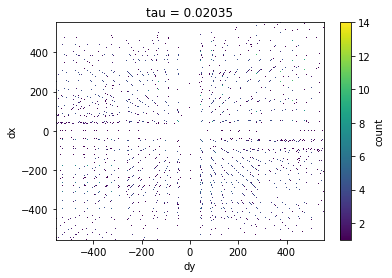

In [63]:
ds["count"].where(ds["count"]>0).plot()

In [67]:

def bin_count(df):
    
    # dev
    df = compute_deltas(df)
    
    tau_min, tau_max = _df["dt"].min(), _df["dt"].max()

    # should loop in practice
    tau = tau_min

    # subselect
    _df_tau = _df.set_index("dt").loc[tau]

    # compute stats
    s =_df_tau.groupby(["dx", "dy", "dt"])["uu"].agg(["sum", "count"])
    s.index = s.index.map(lambda i: (i[0].mid, i[1].mid, i[2].mid))
    #s =_df_tau.groupby(["dx", "dy"])["uu"].agg(["sum", "count"])
    #s.index = s.index.map(lambda i: (i[0].mid, i[1].mid))

    # to xarray
    #ds = s.to_xarray()
    #ds = ds.expand_dims("tau").assign_coords(tau=[tau.mid])
    
    return s

out = merged_ddf.map_partitions(bin_count)
out

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x2aaba855ea00>>
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/utils_perf.py", line 192, in _gc_callback
    self._fractional_timer.start_timing()
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/utils_perf.py", line 115, in start_timing
    assert self._cur_start is None
AssertionError: 


,sum,count
npartitions=173,,
,float32,int64
,...,...
...,...,...
,...,...
,...,...


In [70]:
outf = out.groupby(out.index).sum().compute()

In [71]:
outf

,sum,count
"(-554.0, -554.0, 0.02035)",0.0,0
"(-554.0, -552.0, 0.02035)",0.0,173
"(-554.0, -550.0, 0.02035)",0.0,0
"(-554.0, -548.0, 0.02035)",0.0,0
"(-554.0, -546.0, 0.02035)",0.0,0
...,...,...
"(552.0, 544.0, 0.02035)",0.0,0
"(552.0, 546.0, 0.02035)",0.0,0
"(552.0, 548.0, 0.02035)",0.0,0
"(552.0, 550.0, 0.02035)",0.0,0


In [72]:
outf.to_xarray()

<xarray.Dataset>
Dimensions:  (index: 306916)
Coordinates:
  * index    (index) object (-554.0, -554.0, 0.02035) ... (552.0, 552.0, 0.02...
Data variables:
    sum      (index) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    count    (index) int64 0 173 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0

In [68]:
outm = out.get_partition(1).compute()
outm

sum  count
dx     dy     dt                 
-554.0 -554.0 0.02035  0.0      0
       -552.0 0.02035  0.0      1
       -550.0 0.02035  0.0      0
       -548.0 0.02035  0.0      0
       -546.0 0.02035  0.0      0
...                    ...    ...
 552.0  544.0 0.02035  0.0      0
        546.0 0.02035  0.0      0
        548.0 0.02035  0.0      0
        550.0 0.02035  0.0      0
        552.0 0.02035  0.0      0

[306916 rows x 2 columns]

In [69]:
outm.index

MultiIndex([(-554.0, -554.0, 0.02035),
            (-554.0, -552.0, 0.02035),
            (-554.0, -550.0, 0.02035),
            (-554.0, -548.0, 0.02035),
            (-554.0, -546.0, 0.02035),
            (-554.0, -544.0, 0.02035),
            (-554.0, -542.0, 0.02035),
            (-554.0, -540.0, 0.02035),
            (-554.0, -538.0, 0.02035),
            (-554.0, -536.0, 0.02035),
            ...
            ( 552.0,  534.0, 0.02035),
            ( 552.0,  536.0, 0.02035),
            ( 552.0,  538.0, 0.02035),
            ( 552.0,  540.0, 0.02035),
            ( 552.0,  542.0, 0.02035),
            ( 552.0,  544.0, 0.02035),
            ( 552.0,  546.0, 0.02035),
            ( 552.0,  548.0, 0.02035),
            ( 552.0,  550.0, 0.02035),
            ( 552.0,  552.0, 0.02035)],
           names=['dx', 'dy', 'dt'], length=306916)

In [ ]:
def bin_deltas_dxdy(df):
    #_df = df.copy()
    # compute deltas and round
    dx = pa.haversine(df["lon_right"], df["lat_right"], df["lon_left"], df["lat_right"])
    df["dx"] = pd.cut(dx, bins=x_bins).rename("dx")
    #
    dy = pa.haversine(df["lon_right"], df["lat_right"], df["lon_right"], df["lat_left"])
    df["dy"] = pd.cut(dy, bins=y_bins).rename("dy")
    #
    df["uu"] = df["zonal_velocity_left"] * df["zonal_velocity_right"]
    out = df.groupby(["dx", "dy"])["uu"].mean()
    return out

In [ ]:
df = _df 

# compute deltas and round
dx = pa.haversine(df["lon_right"], df["lat_right"], df["lon_left"], df["lat_right"])
dx = pd.cut(dx, bins=x_bins).rename("dx")
#
dy = pa.haversine(df["lon_right"], df["lat_right"], df["lon_right"], df["lat_left"])
dy = pd.cut(dy, bins=y_bins).rename("dy")
#
dt = (df["time_right"]-df["time_left"])/pd.Timedelta("1D")
dt = pd.cut(dt, bins=tau_bins, include_lowest=True).rename("dt")
#
out = df.groupby([dt, dx, dy]).mean()

In [ ]:
out

In [ ]:
dt

In [ ]:
out = out.compute()

In [ ]:
merged_ddf.head()

In [ ]:
import dask

In [ ]:

#def find_pairs(df_small, df):

# distribute locally pair finding

# https://docs.dask.org/en/latest/scheduling.html
# reset dask cluster locally
dask.config.set(scheduler="threads")

# subselect time 
tmin = str(df_small.index.min())
tmax_plus_delta = str(df_small.index.max()+pd.Timedelta('30d'))
df = df.loc[tmin:tmax_plus_delta]

_df = df.get_partition(1).compute()

#dt = 

http://kuanbutts.com/2017/06/18/dask-geoprocessing/

In [ ]:
merged_ddf = dd.merge(ddf, df, on="temp_key", suffixes=("_left", "_right"))

In [ ]:
df_small.size

In [ ]:
df_small.size*3*4/1e6 # check partition size computation

```
n x n_small x 4 < memory_available * 1e9 # memory available in GB
```

```
n = psize*1e6/3/4  # psize partition size in MB
n_small = psize_small*1e6/3/4  # psize partition size in MB
```


In [ ]:
1200*3*4/1e6

In [ ]:
df.npartitions

In [ ]:
_df = df.get_partition(0).compute()
_df.size

In [ ]:
6294807*147888 *4/1e9

In [ ]:
6294807*4/1e6

In [ ]:
# transform into geopandas dataframe
gdf_fguess = gpd.GeoDataFrame(
    df_fguess, 
    geometry=gpd.points_from_xy(df_fguess.lon, df_fguess.lat),
    crs=crs_wgs84,
)

# narrow selection
gdf_narrow = gpd.sjoin(gdf_fguess, _box, how='inner', op='intersects')
gdf_narrow.plot()
gdf_narrow.head()

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


---

In [17]:
cluster.close()